# Resonance frequency of soil from FarmDAS

In [73]:
import os
import h5py
import math
import time
import matplotlib
import numpy as np
import pandas as pd

from obspy import UTCDateTime
from datetime import datetime
from datetime import timedelta
from functools import partial
from scipy.signal import butter
from scipy.signal import detrend
from scipy.signal import decimate
from scipy.signal import filtfilt
from scipy.signal import spectrogram
from multiprocessing import Pool
from matplotlib import pyplot as plt
from das_util import read_decimate, get_tstamp, calc_NFFT

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## Step 1- Quality control of metadata

In [74]:
# %% sort the files
data_dir = '/1-fnp/petasaur/p-wd05/harper_plots'
file_list = np.array(os.listdir(data_dir))
acqu_time = np.array([get_tstamp(i) for i in file_list])

new_index = np.argsort(np.array(acqu_time)-acqu_time[0])
file_list = file_list[new_index]
acqu_time = acqu_time[new_index]
file_path = [os.path.join(data_dir,i) for i in file_list]

print('Total number of files:', len(file_path))

Total number of files: 3395


In [75]:
# %% the stable acquisition time period
list_all = np.arange(28,2468)
num_file = len(list_all)

# %% meta data
gauge_length_all = np.zeros(num_file, dtype=np.float64)
delta_space_all = np.zeros(num_file, dtype=np.float64)
num_channel_all = np.zeros(num_file, dtype=np.float64)
sample_rate_all = np.zeros(num_file, dtype=np.float64)
num_sample_all = np.zeros(num_file, dtype=np.float64)

for i,j in enumerate(list_all):
    with h5py.File(file_path[j],'r') as f:      
        gauge_length_all[i] = f['Acquisition'].attrs['GaugeLength']
        delta_space_all[i] = f['Acquisition'].attrs['SpatialSamplingInterval']
        sample_rate_all[i]  = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
        num_channel_all[i] = f['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
        num_sample_all[i]  = len(f['Acquisition']['Raw[0]']['RawDataTime'][:])
        
# %% exclude files that drop samples
ind_good = np.where(num_sample_all == 120000)[0]
gauge_length_all = gauge_length_all[ind_good]
delta_space_all = delta_space_all[ind_good]
sample_rate_all = sample_rate_all[ind_good]
num_channel_all = num_channel_all[ind_good]
num_sample_all = num_sample_all[ind_good]
list_all = list_all[ind_good]

print(f'good acqusition for {len(ind_good)} minutes')

good acqusition for 2408 minutes


Text(0.5, 1.0, 'distribution of metadata')

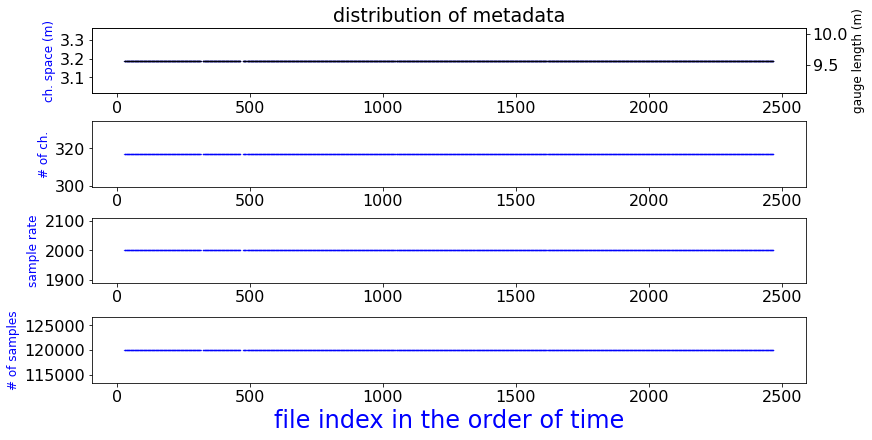

In [76]:
# %% visualize the metadata during good acqusition
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(12, 6), constrained_layout=True)

ax[0].scatter(list_all, delta_space_all, marker='o', s=0.1, edgecolors='b')
axcopy = ax[0].twinx()
axcopy.scatter(list_all, gauge_length_all, marker='o', s=0.1, edgecolors='k')
ax[1].scatter(list_all, num_channel_all, marker='o', s=0.1, edgecolors='b')
ax[2].scatter(list_all, sample_rate_all, marker='o', s=0.1, edgecolors='b')
ax[3].scatter(list_all, num_sample_all, marker='o', s=0.1, edgecolors='b')

axcopy.set_ylabel("gauge length (m)", fontsize = 12, color='k')
ax[0].set_ylabel("ch. space (m)", fontsize = 12, color='b')
ax[1].set_ylabel("# of ch.", fontsize = 12, color='b')
ax[2].set_ylabel("sample rate", fontsize = 12, color='b')
ax[3].set_ylabel("# of samples", fontsize = 12, color='b')
ax[3].set_xlabel("file index in the order of time", fontsize = 24, color='b')
ax[0].set_title('distribution of metadata')

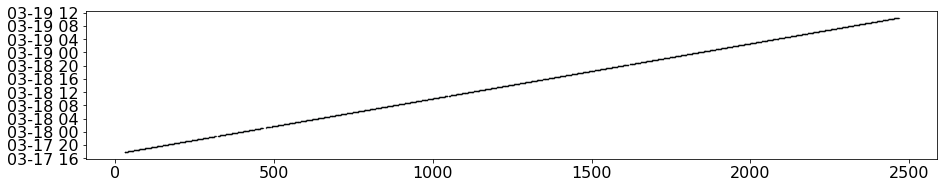

In [77]:
# %% See if the acquisition time is continuous
file_list = file_list[list_all]
acqu_time = acqu_time[list_all]
file_path = [os.path.join(data_dir,i) for i in file_list]
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(13, 2.5), constrained_layout=True)
ax.scatter(list_all, acqu_time.astype('datetime64[m]'), marker='o', s=0.1, edgecolors='k')

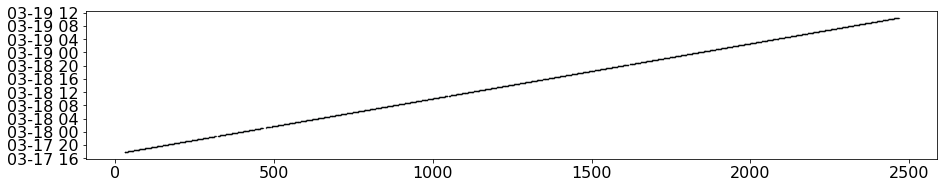

In [78]:
h5_datetime_format = "%Y-%m-%d %H:%M:%S %Z%z"
time_stamp = np.array([i.timestamp for i in acqu_time])
time_save = np.array([UTCDateTime(i) for i in time_stamp])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(13, 2.5), constrained_layout=True)
ax.scatter(list_all, time_save.astype('datetime64[m]'), marker='o', s=0.1, edgecolors='k')

## Step 2- Spectrograms

### Select: 0-36 hours | Channel 44-94 (SW buried segment)

In [79]:
start_ch, end_ch = 44, 94            # channel range
ch_id = 33                           # choose a channel to visualize
start_minutes = 0                    # starting file indice for reading
num_minutes = 2160                    # number of semi-continuous 1-min files to merge
num_seconds = int(num_minutes * 60)  # total duration (s) of merged time series
dsamp_factor = 20                    # downsample rate when reading raw time series
sample_rate = int(2000 / dsamp_factor)    # final sample rate after downsampling
shift_min = 7                        # shift in minutes of the first tick when ploting
shift_sec = int(shift_min * 60)      # shift in seconds
file_inc = 360                       # plot ticks for every {file_inc} 1-min files 
time_inc = int(file_inc * 60)        # tick interval in seconds

### The next 3 cells read the data, slowly

In [26]:
# %% read the raw data file
# %% could be the most time-consuming
# %% Do Not run this cell after the FIRST time
# %% instead, run the next cell 
since = time.time()

# %% multi-process to read and decimate lots of files 
num_proc = 20   # number of threads (too large number kills the memory) 
partial_func = partial(read_decimate, dsamp_factor=dsamp_factor, start_ch=start_ch, end_ch=end_ch)
with Pool(processes=num_proc) as pool:   # pool is closed automatically and join as a list
    print("# threads: ", num_proc)
    full_time = pool.map(partial_func, file_path[start_minutes:start_minutes+num_minutes])

# %% concatenate the list elements in time
full_time_data = np.concatenate(full_time, axis=1)

print(f'time used: {time.time()- since:.1f}')
print(f'final shape: {full_time_data.shape}')
print(f'sample rate: {sample_rate:.0f}')

# %% save it to HDF5 for future use
datah5 = '/data/whd01/qibin_data/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'w') as f:
    f.create_dataset("data", data=full_time_data)
    f.create_dataset("timestamp", data=time_stamp)
    f.create_dataset("dt", data=sample_rate)

# threads:  20
time used: 1061.0
final shape: (50, 12960000)
sample rate: 100


TypeError: No conversion path for dtype: dtype('<U20')

In [84]:
# %% Run this cell only after the FIRST time
# %% read from the saved HDF5
datah5 = '/data/whd01/qibin_data/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'r') as f:
    full_time_data_h5 = f["data"][:]
    sample_rate_h5 = f["dt"][()]
    time_stamp_h5 = f["timestamp"][:]
full_time_data = full_time_data_h5
sample_rate = sample_rate_h5
acqu_time = np.array([UTCDateTime(i) for i in time_stamp_h5])

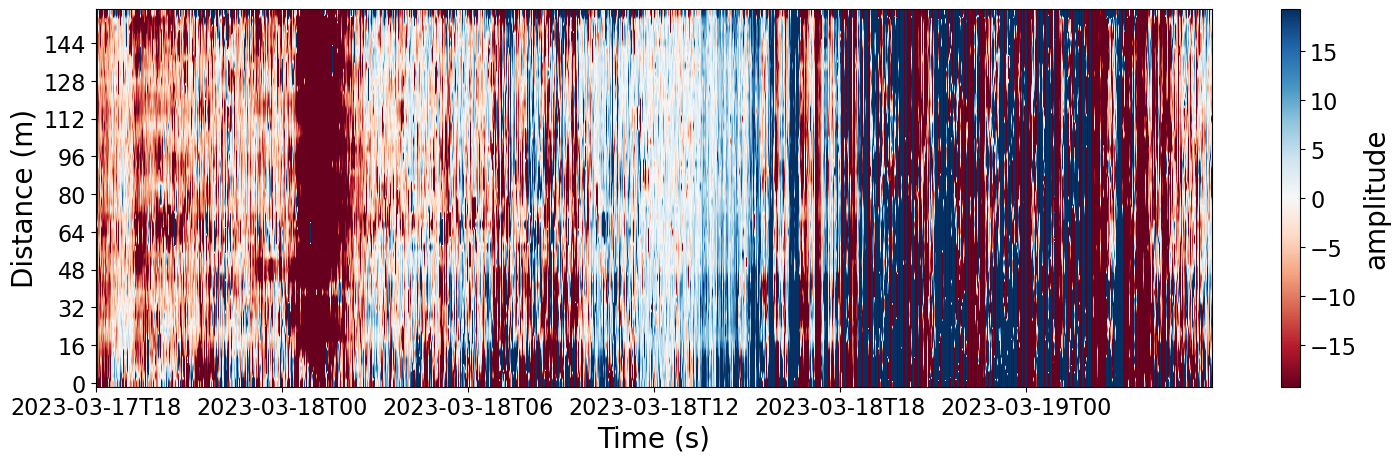

In [85]:
# %% plot data in time-space
max_amp = np.median(np.fabs(full_time_data))*2
plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.imshow(full_time_data, aspect = 'auto', cmap = 'RdBu', vmax = max_amp, vmin = -max_amp, origin='lower')
plt.ylabel("Distance (m)", fontsize = 20)
plt.xlabel("Time (s)", fontsize = 20)
plt.xticks(np.arange(0+shift_sec, num_seconds * sample_rate, time_inc*sample_rate), 
           acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[h]'))
plt.yticks(np.arange(0, end_ch-start_ch, 5), 
           np.rint(np.arange(0, delta_space_all[0]*(end_ch-start_ch), 5*delta_space_all[0])).astype(int))
cbr=plt.colorbar()
cbr.set_label('amplitude', fontsize = 20)

In [90]:
# %% calculate the best NFFT for plotting
nfft, time_width = calc_NFFT(full_time_data[33], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')

NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds


(819, 1807) (819,) (1807,)
(2047, 1807) (2047,) (1807,)


[Text(420, 0, '2023-03-17T18:00'),
 Text(22020, 0, '2023-03-18T00:08'),
 Text(43620, 0, '2023-03-18T06:21'),
 Text(65220, 0, '2023-03-18T12:24'),
 Text(86820, 0, '2023-03-18T18:25'),
 Text(108420, 0, '2023-03-19T00:28')]

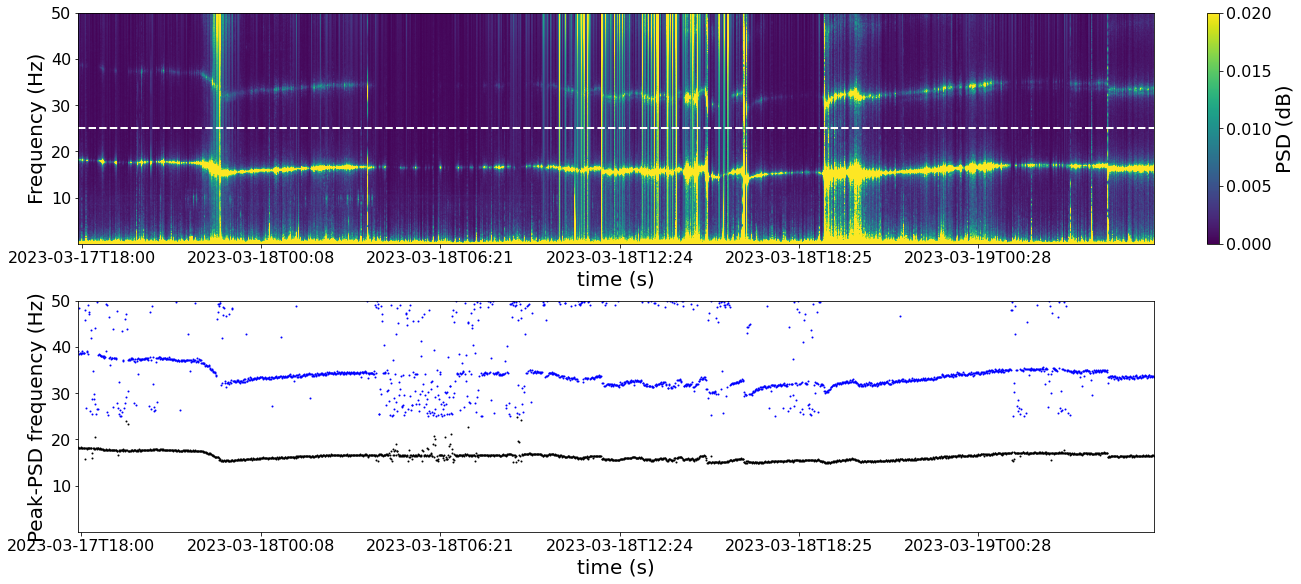

In [91]:
# %% plot data in time-frequency
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(18, 8), constrained_layout=True)
Pxx,freqs,bins,image=ax[0].specgram(full_time_data[ch_id],Fs=sample_rate,
                                    mode='magnitude',NFFT=nfft,noverlap=int(nfft/8), 
                                    scale='linear', vmin=0, vmax=0.02)
hline = ax[0].axhline(25, linestyle='--', linewidth=2, color='w') 
cbr = fig.colorbar(image, ax=ax[0])
cbr.set_label('PSD (dB)', fontsize = 20)

# ax[0].set_yscale("log")
ax[0].set_ylim(2/time_width, sample_rate/2)
ax[0].set_xlabel("time (s)", fontsize = 20)
ax[0].set_ylabel("Frequency (Hz)", fontsize = 20)

# %% set up time ticks for every 20 minutes (20 1-min files)
ax[0].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[0].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))


# %% 1st mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 15, freqs < 25))[0]
Pxx1 = Pxx[ind, :]
freqs1 = freqs[ind]
# %% 2nd mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 25, freqs < 50))[0]
Pxx2 = Pxx[ind, :]
freqs2 = freqs[ind]

freq_ind1 = np.argmax(Pxx1, axis=0)
freq_ind2 = np.argmax(Pxx2, axis=0)
print(Pxx1.shape, freqs1.shape, freq_ind1.shape)
print(Pxx2.shape, freqs2.shape, freq_ind2.shape)

ax[1].scatter(bins, freqs1[freq_ind1], marker='o', s=1, edgecolors='k')
ax[1].scatter(bins, freqs2[freq_ind2], marker='o', s=1, edgecolors='b')
ax[1].set_ylim(2/time_width, sample_rate/2)
ax[1].set_xlim(bins[0], bins[-1])
ax[1].set_xlabel("time (s)", fontsize = 20)
ax[1].set_ylabel("Peak-PSD frequency (Hz)", fontsize = 20)
ax[1].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[1].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))

## Step 3- Extract frequencies of peak Power Spectral Density (PSD)

### manually check each channel (try and modify bd&nmode)

In [ ]:
########################################
### bd: boundaries between two modes ###
### nmode: 0-no, 1-1st, 2-2nd, 3-both ##
bd = [20,20,20,20,20,20,20,20,20,20,
      20,20,20,20,20,20,20,20,20,20,
      20,20,20,20,20,20,20,20,20,20,
      20,20,20,20,20,20,20,20,20,20,
      20,20,25,25,35,35,35,32,32,32]
nmode = [2,2,2,2,2,2,0,0,2,2,
         2,2,2,2,2,2,2,2,3,3,
         3,3,2,2,2,2,2,2,2,2,
         2,3,3,3,3,3,1,0,0,0,
         0,0,0,0,1,1,1,1,2,2]
#########################################
print('The numbers below should be equal')
print('# of all channels:', end_ch-start_ch)
print('# of modes bounds:', len(bd))
print('# of modes counts:', len(nmode))

plt.close('all')
fig, ax = plt.subplots((end_ch-start_ch), 1, figsize=(18, 200), constrained_layout=True)

for ich in np.arange(0,end_ch-start_ch):
    Pxx, freqs, bins, image = ax[ich].specgram(full_time_data[ich], Fs=sample_rate,
                                    mode='magnitude',NFFT=nfft,noverlap=int(nfft/8), 
                                    scale='linear', vmin=0, vmax=0.01)
    hline = ax[ich].axhline(bd[ich], linestyle='--', linewidth=2, color='w')
    hline = ax[ich].axhline(13, linestyle='--', linewidth=1, color='w')
    ax[ich].set_ylim(8, sample_rate/2)
    ax[ich].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
    ax[ich].set_xticklabels(
        acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
    cbr = fig.colorbar(image, ax=ax[ich])
    cbr.set_label('magnitude (dB)', fontsize = 20)
    ax[ich].set_title(f'Spectrogram for 0-12 hour at channel {ich}')
    ax[ich].set_ylabel("Frequency (Hz)", fontsize = 20)

### visualize resonance frequencies

In [ ]:
#########################################
nmode = [0,0,0,0,0,0,0,0,2,2,
         2,2,2,2,2,2,2,2,3,3,
         3,3,0,2,2,2,2,2,2,2,
         2,2,3,3,3,3,1,0,0,0,
         0,0,0,0,1,1,1,0,2,2]
#########################################

# %% calculate sampling parameters for spectrogram
nfft, time_width = calc_NFFT(full_time_data[ch_id], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')


In [ ]:
# %% get Peak frequency of all channels
dominant_freq = np.ones((int(end_ch-start_ch), 2, bins.shape[0]), dtype=np.float32) * 50
%matplotlib agg
for ich in np.arange(end_ch-start_ch):
    plt.close('all')
    Pxx, freqs, bins, image = plt.specgram(full_time_data[ich], Fs=sample_rate, 
                                           mode='psd', NFFT=nfft, noverlap=int(nfft/8))
    
    # %% 1st mode resonance of every time bin
    ind = np.where(np.logical_and(freqs > 13, freqs < bd[ich]))[0]
    Pxx1 = Pxx[ind, :]
    freqs1 = freqs[ind]
    # %% 2nd mode resonance of every time bin
    ind = np.where(np.logical_and(freqs > bd[ich], freqs < 50))[0]
    Pxx2 = Pxx[ind, :]
    freqs2 = freqs[ind]

    freq_ind1 = np.argmax(Pxx1, axis=0)
    freq_ind2 = np.argmax(Pxx2, axis=0)
    
    if nmode[ich] == 3:
        dominant_freq[ich, 0, :] = freqs1[freq_ind1]
        dominant_freq[ich, 1, :] = freqs2[freq_ind2]
    elif nmode[ich] == 2:
        dominant_freq[ich, 1, :] = freqs2[freq_ind2]
    elif nmode[ich] == 1:
        dominant_freq[ich, 0, :] = freqs1[freq_ind1]

In [ ]:
# %% Plotting
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.close('all')
fig, ax = plt.subplots(7, 1, figsize=(18, 40), constrained_layout=True)

# %% Spectrogram
Pxx, freqs, bins, image = ax[0].specgram(full_time_data[ch_id], Fs=sample_rate, 
                                         mode='psd', NFFT=nfft, noverlap=int(nfft/8))
hline = ax[0].axhline(25, linestyle='--', linewidth=2, color='w') 
ax[0].set_ylim(2/time_width, sample_rate/2)
ax[0].set_ylabel("Frequency (Hz)", fontsize = 20)
ax[0].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[0].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
cbr = fig.colorbar(image, ax=ax[0])
cbr.set_label('PSD (dB)', fontsize = 20)
ax[0].set_title('Spectrogram of 0-12 hour')

# %% 1st resonance frequency --all channels
image = ax[1].imshow(dominant_freq[:, 0, :], cmap='hot', interpolation='nearest', aspect='auto')
hline = ax[1].axhline(ch_id, linestyle='--', linewidth=3, color='b') 
ax[1].set_ylim(0, end_ch-start_ch)
ax[1].set_xlabel("time (s)", fontsize = 20)
ax[1].set_ylabel("distance (m)", fontsize = 20)
ax[1].set_xticks(np.arange(0+shift_sec/(time_width*7/8), dominant_freq.shape[-1], time_inc/(time_width*7/8)))
ax[1].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
ax[1].set_yticks(np.arange(0, end_ch-start_ch, 5))
ax[1].set_yticklabels(np.rint(np.arange(0, delta_space_all[0]*(end_ch-start_ch), 5*delta_space_all[0])).astype(int))
cbr = fig.colorbar(image, ax=ax[1])
cbr.set_label('peak frequency (Hz)', fontsize = 20)
ax[1].set_title('1st resonance frequency in space and time during 0-12 hour')

# %% 2nd resonance frequency --all channels
image = ax[2].imshow(dominant_freq[:, 1, :], cmap='hot', interpolation='nearest', aspect='auto')
hline = ax[2].axhline(ch_id, linestyle='--', linewidth=3, color='b') 
ax[2].set_ylim(0, end_ch-start_ch)
ax[2].set_xlabel("time (s)", fontsize = 20)
ax[2].set_ylabel("distance (m)", fontsize = 20)
ax[2].set_xticks(np.arange(0+shift_sec/(time_width*7/8), dominant_freq.shape[-1], time_inc/(time_width*7/8)))
ax[2].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
ax[2].set_yticks(np.arange(0, end_ch-start_ch, 5))
ax[2].set_yticklabels(np.rint(np.arange(0, delta_space_all[0]*(end_ch-start_ch), 5*delta_space_all[0])).astype(int))
cbr = fig.colorbar(image, ax=ax[2])
cbr.set_label('peak frequency (Hz)', fontsize = 20)
ax[2].set_title('2nd resonance frequency in space and time during 0-12 hour')


# %% resonance frequency curves of selected channels
for ich in np.arange(end_ch-start_ch):
    # %% 1st reso-freq
    if nmode[ich] == 3:
        ax[3].scatter(bins, dominant_freq[ich, 0, :], marker='o', s=10, label=f'{ich}')
        ax[4].scatter(bins, dominant_freq[ich, 1, :], marker='o', s=10, label=f'{ich}')
        if ich > 30:
            ax[5].scatter(bins, dominant_freq[ich, 1, :]/dominant_freq[ich, 0, :], marker='o', s=20, label=f'{ich}')
            ax[6].scatter(bins, dominant_freq[ich, 1, :]-dominant_freq[ich, 0, :], marker='o', s=20, label=f'{ich}')
    elif nmode[ich] == 2:
        ax[4].scatter(bins, dominant_freq[ich, 1, :], marker='o', s=10, label=f'{ich}')
    elif nmode[ich] == 1:
        ax[3].scatter(bins, dominant_freq[ich, 0, :], marker='o', s=10, label=f'{ich}')

ax[3].legend(loc='lower right')
ax[3].set_ylabel("frequency", fontsize = 20)
ax[3].set_title('1st resonance frequency')
ax[3].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[3].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
ax[4].legend(loc='lower right', ncol=2)
ax[4].set_ylabel("frequency", fontsize = 20)
ax[4].set_title('2nd resonance frequency')
ax[4].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[4].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
ax[5].legend(loc='lower right')
ax[5].set_ylabel("freq2 / freq1", fontsize = 20)
ax[5].set_title('frequency ratio')
ax[5].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[5].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))
ax[6].legend(loc='lower right')
ax[6].set_ylabel("freq2 - freq1", fontsize = 20)
ax[6].set_title('frequency difference')
ax[6].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[6].set_xticklabels(acqu_time[start_minutes+shift_min:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))